In [1]:
import pydicom
from pydicom import dcmread

import matplotlib.pyplot as plt
import numpy as np
import scipy as st
from scipy.constants import e, h, hbar, alpha, c, m_e

from numba import jit
import cv2

from scipy.signal import convolve2d

import os

import density_map_library as den
import projection_library as pro

In [2]:
in_dir_path = "./infile"
mat_dir_path = "./material_info"
model = pro.import_dicom(in_dir_path)
model_kVp = den.find_model_kVp(in_dir_path)

interval = 5
anode_atomic_number = 74
filter_thickness = 0.5


predicted_CT_numbers = den.predict_CT_numbers_poly(mat_dir_path, model_kVp, interval, anode_atomic_number, filter_thickness)
tissue_ranges = den.find_tissue_ranges(predicted_CT_numbers)

mass_densities = den.mass_density_dictionary(mat_dir_path)

density_map = den.find_density_map(model, tissue_ranges, predicted_CT_numbers, mass_densities)

In [3]:
def N_P_integral(lam, lamp):
    from scipy.constants import hbar, alpha, c, m_e
    con = -((hbar*alpha)**2) / (2*(m_e*c)**2)
    return con/2*(6*np.log(np.abs(lamp)) + 2*lamp*lam + 2*lam/lamp + 1/lamp**2)

In [4]:
def N_P_definite_integrate_proportion(start, end, KeV):
        
    if(180<start < 0 or 180<end < 0):
        print("please give positive values for start and end between 0-180, in degrees")
    
    start = start * np.pi/180
    end = end * np.pi/180
    
    lam = h * c/(KeV * 1000 * e)
    
    max_lamp = lam + (h/(m_e *c)) * (1-np.cos(0))
    min_lamp = lam + (h/(m_e *c)) * (1-np.cos(np.pi))
    
    lamp_range = max_lamp - min_lamp
    
    max_range_integral_start =  N_P_integral(lam, lam)
    max_range_integral_end = N_P_integral(lam, min_lamp) 
    
    max_range_integral = max_range_integral_end - max_range_integral_start
    
    lamp_start = lam + (h/(m_e *c)) * (1-np.cos(start))
    lamp_end = lam + (h/(m_e *c)) * (1-np.cos(end))
    
    lamp_start_integral = N_P_integral(lam, lamp_start)
    lamp_end_integral = N_P_integral(lam, lamp_end)
    
    lamp_range_integral = lamp_end_integral - lamp_start_integral
    
    lamp_range_integral_proportion = lamp_range_integral/max_range_integral
    
    return lamp_range_integral_proportion


In [5]:
def angle_intensity(angle, KeV):
    class_electron_radius = st.constants.physical_constants["classical electron radius"][0]
    angle = angle * np.pi/180
    lam = h * c/(KeV * 1000 * e)
    lamp = lam + (h/(m_e *c)) * (1-np.cos(angle))
    con = 0.5 * class_electron_radius **2
    multi_one = (lam/lamp)**2
    multi_two = lam/lamp + lamp/lam - np.sin(angle)**2
    #klein_nishina_differential split into con, multi_one, and multi_two for clarity and neatness
    
    #radiation scatters through a sphere. Angles close to 90 scatter over a wider radius. The next section acounts for this
    scatter_circumference = 2*np.sin(angle) * np.pi
    
    return con*multi_one*multi_two / scatter_circumference

In [6]:
def voxel_convolution(vox_z, vox_y, vox_x, object_shape, source_object_distance,object_image_distance, kernel_size, KeV):
    source_image_distance = source_object_distance + object_image_distance + object_shape[0]
    max_mag = ((source_image_distance)/(source_object_distance))
    image_shape = np.array((object_shape[1]*max_mag, object_shape[2]*max_mag))
    
    
    source_z = - source_object_distance
    # minus because down is accending in array structure
    source_y = image_shape[0]/2
    source_x = image_shape[1]/2
    
    source_coord = np.array((source_z, source_y,source_x))
    
    vox_zd = vox_z
    vox_yd = vox_y + image_shape[0]/2 - object_shape[1]
    vox_xd = vox_x + image_shape[1]/2 - object_shape[2]
    
    vox_coord = np.array((vox_zd,vox_yd,vox_xd))
    source_vox_vector = vox_coord - source_coord

    
    
    grad_z = vox_z - source_z
    grad_y = vox_yd - source_y
    grad_x = vox_xd - source_x
    
    #Z = grad_z*t + vox_z (z component of vector)
    #Z = object_image_distance when vector intersects detector
    t = (object_image_distance - vox_zd)/grad_z
    
    #Y = grad_y*t + vox_y (formula for y component of vector)
    #X = grad_x*t + vox_x(formula for x component of vector)
    
    kernel_centre_y = grad_y*t + vox_y
    kernel_centre_x = grad_x*t + vox_x
    
 
    kernel_y_min = round(kernel_centre_y - kernel_size/2)
    kernel_x_min = round(kernel_centre_x - kernel_size/2)
    
    scatter_angles = np.zeros((kernel_size,kernel_size))
    
    
    y = 0
    x = 0
    while y < kernel_size:
        x = 0
        while x < kernel_size:
            pix_coord = np.array((object_image_distance,kernel_y_min + y, kernel_x_min + x))
            vox_pix_vector = pix_coord - vox_coord
            scatter_angles[y][x] = np.arccos(np.dot(source_vox_vector, vox_pix_vector) / (np.linalg.norm(source_vox_vector) * np.linalg.norm(vox_pix_vector)))
            x = x + 1
        y = y + 1
        
    
    scatter_angles = 180 - scatter_angles*180/np.pi
    #converts to degrees, also reorientates
    
    kernel =  angle_intensity(scatter_angles, KeV)
    
    #N_P_definite_integrate_proportion(start, end, KeV)
    #find percentage of scatter included in kernel
    
    #angles left, right, up and down
    to_leftmost = scatter_angles[round(len(scatter_angles/2)) -1][0]
    to_rightmost = scatter_angles[round(len(scatter_angles/2)) -1][-1]
    to_upmost = scatter_angles[0][round(len(scatter_angles/2)) -1]
    to_downmost = scatter_angles[-1][round(len(scatter_angles/2))-1]
    vox_angle = scatter_angles[round(len(scatter_angles/2))-1][round(len(scatter_angles/2))-1]
    
    #scattered to each boundary
    
    leftwards_proportion = N_P_definite_integrate_proportion(to_leftmost, vox_angle, KeV)
    rightwards_proportion = N_P_definite_integrate_proportion(to_rightmost, vox_angle, KeV)
    upwards_proportion = N_P_definite_integrate_proportion(to_upmost, vox_angle, KeV)
    downwwards_proportion = N_P_definite_integrate_proportion(to_downmost, vox_angle, KeV)
    
    
    left_or_right = leftwards_proportion + rightwards_proportion
    up_or_down = upwards_proportion + downwwards_proportion
    
    in_bounds_proportion = left_or_right * up_or_down
    
    
    #accounts for scatter outside of the kernel size
    kernel = kernel * in_bounds_proportion
    
    kernel_sum = kernel.sum()
    
    #calculates the intensity of each pixel as a proportion of radiation scattered onto detector
    kernel = kernel/kernel_sum
    
    
    return kernel
    

    
    

In [7]:
def find_section_convolutions(object_shape, sections_cubed_root, source_object_distance, object_image_distance, kernel_size, KeV):
    
    section_dimentions = object_shape/sections_cubed_root
    section_centre = section_dimentions/2
    section_origins_z = np.arange(0, object_shape[0], section_dimentions[0])
    section_origins_y = np.arange(0, object_shape[1], section_dimentions[1])
    section_origins_x = np.arange(0, object_shape[2], section_dimentions[2])
    
    
    section_centres_z = section_origins_z + section_centre[0]
    section_centres_y = section_origins_y + section_centre[1]
    section_centres_x = section_origins_x + section_centre[2]
    
    section_centres = np.stack((section_centres_z,section_centres_y,section_centres_x),0)
    
    
    section_convolutions = np.zeros((sections_cubed_root, sections_cubed_root, sections_cubed_root,kernel_size,kernel_size))
    
    vox_z_section_index = 0
    vox_y_section_index = 0
    vox_x_section_index = 0
    
    while vox_z_section_index < sections_cubed_root:
        vox_y_section_index = 0
        while vox_y_section_index < sections_cubed_root:
            vox_x_section_index = 0
            while vox_x_section_index < sections_cubed_root:
                
                vox_z = int(section_centres[0][vox_z_section_index])
                vox_y = int(section_centres[1][vox_y_section_index])
                vox_x = int(section_centres[2][vox_x_section_index])
                section_convolution = voxel_convolution(vox_z, vox_y, vox_x, object_shape, source_object_distance,object_image_distance, kernel_size, KeV)
                section_convolutions[vox_z_section_index][vox_y_section_index][vox_x_section_index] = section_convolution
                
                vox_x_section_index = vox_x_section_index + 1
           
            vox_y_section_index = vox_y_section_index + 1
            
        vox_z_section_index = vox_z_section_index + 1
            
    
    return section_convolutions
                 
    

In [8]:
def section_model(model,sections_cubed_root):
    
        
    z_mod = len(model) % sections_cubed_root
    if z_mod == 0:
        z_extra = 0
    else:
        z_extra = sections_cubed_root - z_mod
    
    y_mod = len(model[0]) % sections_cubed_root
    if y_mod == 0:
        y_extra = 0
    else:
        y_extra = sections_cubed_root - y_mod
    
    x_mod = len(model[0][0]) % sections_cubed_root
    if x_mod == 0:
        x_extra = 0
    else:
        x_extra = sections_cubed_root - x_mod
        
        
    
    stretched_model_size = np.array((len(model) + z_extra, len(model[0]) + y_extra, len(model[0][0]) + x_extra ))
    
    
    stretched_model = np.resize(model, stretched_model_size)
    
    section_size = stretched_model_size/sections_cubed_root
    
    sections = np.zeros((int(sections_cubed_root),int(sections_cubed_root),int(sections_cubed_root),int(section_size[0]), int(section_size[1]),int(section_size[2])))
    
    
    iz = 0
    iy = 0
    ix = 0 
    
    while iz < sections_cubed_root:
        iy = 0
        while iy < sections_cubed_root:
            ix = 0
            while ix < sections_cubed_root:
 
                
                z_segments = np.split(stretched_model,sections_cubed_root,0)
                z_segment = z_segments[iz]
            
                y_segments = np.split(z_segment,sections_cubed_root, 1)
                y_segment = y_segments[iy]
                
                x_segments = np.split(y_segment,sections_cubed_root, 2)
                x_segment = x_segments[ix]
                
                
                
                sections[iz][iy][ix] = x_segment
                
                
                ix = ix + 1
            iy = iy + 1
        iz = iz + 1
        
        
    return sections


In [9]:
def unsegment(sections):
    sections_cubed_root = len(sections)
    section_dimentions = np.array((len(sections[0][0][0]),len(sections[0][0][0][0]),len(sections[0][0][0][0][0])))
    
    object_size = section_dimentions * sections_cubed_root
    
    zy_lineup = sections[0][0][0]
    
    iz = 0
    iy = 1
    ix = 1
    
    
    while iz < sections_cubed_root:
        while iy < sections_cubed_root:
            zy_lineup = np.append(zy_lineup, sections[iz][iy][0], 1)
            iy = iy + 1
        iy = 0
        iz = iz + 1
        
    remodel = np.reshape(zy_lineup, (object_size[0],object_size[1],section_dimentions[2]))
    
    
    while ix < sections_cubed_root:
        
        zy_lineup = sections[0][0][ix]
        iz = 0
        iy = 1
        
        while iz < sections_cubed_root:
            while iy < sections_cubed_root:
                zy_lineup = np.append(zy_lineup, sections[iz][iy][ix], 1)
                iy = iy + 1
            iy = 0
            iz = iz + 1
        
        zy_slice = np.reshape(zy_lineup, (object_size[0],object_size[1],section_dimentions[2]))
        remodel = np.append(remodel, zy_slice,2) 
        ix = ix + 1
    
        
      
    return remodel

In [10]:
def convolve_sectioned_model(sectioned_model, section_convolutions):
    sections_cubed_root = len(sectioned_model)
    
    convolved_extra1 = round((len(section_convolutions[0][0][0]) - 1)/2)
    convolved_extra2 = len(section_convolutions[0][0][0]) - 1 - convolved_extra1

    convolved_sectioned_model = np.zeros_like(sectioned_model)

    iz = 0
    iy = 0
    ix = 0
    
    while iz < sections_cubed_root:
        while iy < sections_cubed_root:
            while ix < sections_cubed_root:
                current_section = sectioned_model[iz][iy][ix]
                convolved_section = np.zeros_like(sectioned_model[0][0][0])
                section_convolution = section_convolutions[iz][iy][ix]
                i = 0
                while i < len(convolved_section):
                    convolved_slice = np.asarray(convolve2d(current_section[i], section_convolution))
                    pad1 = np.arange(0,(convolved_extra1),1)
                    pad2 = np.arange(0,(convolved_extra2),1)
                    convolved_slice = np.delete(convolved_slice, pad1,0)
                    convolved_slice = np.delete(convolved_slice, -pad2,0)
                    
                    convolved_slice = np.delete(convolved_slice, pad1,1)
                    convolved_slice = np.delete(convolved_slice, -pad2,1)
                    
                    convolved_section[i] = convolved_slice
                    i = i + 1
                convolved_sectioned_model[iz][iy][ix] = convolved_section
                ix = ix + 1
            ix = 0
            iy = iy + 1
        iy = 0
        iz = iz + 1
            

    return convolved_sectioned_model
    
    


In [11]:
model = density_map
object_shape = np.asarray(model.shape)
sections_cubed_root = 2
source_object_distance = 100
object_image_distance = 10
kernel_size = 5
KeV = 100

sectioned_model = section_model(model,sections_cubed_root)
section_convolutions = find_section_convolutions(object_shape, sections_cubed_root, source_object_distance, object_image_distance, kernel_size, KeV)

convolved_sectioned_model = convolve_sectioned_model(sectioned_model, section_convolutions)

remodel = unsegment(convolved_sectioned_model)


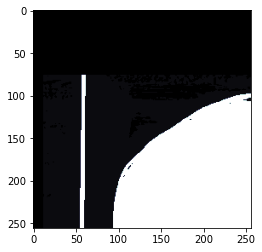

In [12]:
plt.imshow(sectioned_model[0][0][0][50], cmap=plt.cm.bone)

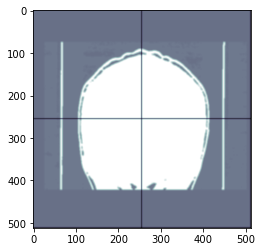

In [13]:
plt.imshow(remodel[51], cmap=plt.cm.bone)